<a href="https://colab.research.google.com/github/jlee703/DataScienceFinal/blob/main/FINAL_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Research question: Do certain anime genres cause more polarization among MyAnimeList (online anime community and databse) users? By polarization I mean contrasts between different users' opinions.**

In [ ]:
#repeat code
import pandas as pd
import requests
import json
import time

data_anime = []

for x in range(1, 10):
  response = requests.get("https://api.jikan.moe/v3/top/anime/" + str(x))
  data_anime.append(response.json())

top500 = []

for x in range(0, len(data_anime)):
  for y in range(0, len(data_anime[x]["top"])):
    top500.append(data_anime[x]["top"][y]['mal_id'])

data_top500 = []

for x in range(len(top500)):
  response = requests.get("https://api.jikan.moe/v3/anime/" + str(top500[x]))
  data_top500.append(response.json())

from pandas.io.json import json_normalize

df_data = json_normalize(data_top500)
df_data.head()

,request_hash,request_cached,request_cache_expiry,mal_id,url,image_url,trailer_url,title,title_english,title_japanese,title_synonyms,type,source,episodes,status,airing,duration,rating,score,scored_by,rank,popularity,members,favorites,synopsis,background,premiered,broadcast,producers,licensors,studios,genres,opening_themes,ending_themes,aired.from,aired.to,aired.prop.from.day,aired.prop.from.month,aired.prop.from.year,aired.prop.to.day,aired.prop.to.month,aired.prop.to.year,aired.string,related.Adaptation,related.Alternative version,related.Side story,related.Spin-off,related.Prequel,related.Sequel,related.Alternative setting,related.Other,related.Character,related.Parent story,related.Summary,related.Full story
0,request:anime:704c9a8ba55a2888accf1b2b89d9d6a2...,True,22478,5114,https://myanimelist.net/anime/5114/Fullmetal_A...,https://cdn.myanimelist.net/images/anime/1223/...,https://www.youtube.com/embed/--IcmZkvL0Q?enab...,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,[Hagane no Renkinjutsushi: Fullmetal Alchemist...,TV,Manga,64.0,Finished Airing,False,24 min per ep,R - 17+ (violence & profanity),9.23,1026080,1,4,1685243,145465,"""In order for something to be obtained, someth...",Fullmetal Alchemist: Brotherhood is an alterna...,Spring 2009,Sundays at 17:00 (JST),"[{'mal_id': 17, 'type': 'anime', 'name': 'Anip...","[{'mal_id': 102, 'type': 'anime', 'name': 'Fun...","[{'mal_id': 4, 'type': 'anime', 'name': 'Bones...","[{'mal_id': 1, 'type': 'anime', 'name': 'Actio...","[""again"" by YUI (eps 1-14), ""Hologram (ホログラム)""...","[""Uso (嘘)"" by SID (eps 1-14), ""LET IT OUT"" by ...",2009-04-05T00:00:00+00:00,2010-07-04T00:00:00+00:00,5,4,2009,4.0,7.0,2010.0,"Apr 5, 2009 to Jul 4, 2010","[{'mal_id': 25, 'type': 'manga', 'name': 'Full...","[{'mal_id': 121, 'type': 'anime', 'name': 'Ful...","[{'mal_id': 6421, 'type': 'anime', 'name': 'Fu...","[{'mal_id': 7902, 'type': 'anime', 'name': 'Fu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,request:anime:5d5d7b307b2951f5792481b68813ac34...,True,86400,28977,https://myanimelist.net/anime/28977/Gintama°,https://cdn.myanimelist.net/images/anime/3/720...,None,Gintama°,Gintama Season 4,銀魂°,[Gintama' (2015)],TV,Manga,51.0,Finished Airing,False,24 min per ep,PG-13 - Teens 13 or older,9.13,104376,2,343,294242,7949,"Gintoki, Shinpachi, and Kagura return as the f...",This is a fourth season of Gintama. In the epi...,Spring 2015,Wednesdays at 18:00 (JST),"[{'mal_id': 16, 'type': 'anime', 'name': 'TV T...","[{'mal_id': 102, 'type': 'anime', 'name': 'Fun...","[{'mal_id': 1258, 'type': 'anime', 'name': 'Ba...","[{'mal_id': 1, 'type': 'anime', 'name': 'Actio...","[""DAY×DAY"" by BLUE ENCOUNT (eps 1-12), ""Pride ...","[""DESTINY"" by Negoto (eps 1-12), ""Saigo made I...",2015-04-08T00:00:00+00:00,2016-03-30T00:00:00+00:00,8,4,2015,30.0,3.0,2016.0,"Apr 8, 2015 to Mar 30, 2016","[{'mal_id': 44, 'type': 'manga', 'name': 'Gint...",NaN,"[{'mal_id': 32122, 'type': 'anime', 'name': 'G...",NaN,"[{'mal_id': 15335, 'type': 'anime', 'name': 'G...","[{'mal_id': 34096, 'type': 'anime', 'name': 'G...",NaN,NaN,NaN,NaN,NaN,NaN
2,request:anime:0bbd7177b3209910d7cd2da3493a8f83...,True,81015,9253,https://myanimelist.net/anime/9253/Steins_Gate,https://cdn.myanimelist.net/images/anime/5/731...,https://www.youtube.com/embed/27OZc-ku6is?enab...,Steins;Gate,Steins;Gate,STEINS;GATE,[],TV,Visual novel,24.0,Finished Airing,False,24 min per ep,PG-13 - Teens 13 or older,9.13,758311,3,7,1382318,122022,The self-proclaimed mad scientist Rintarou Oka...,Steins;Gate is based on 5pb. and Nitroplus' .,Spring 2011,Wednesdays at 02:05 (JST),"[{'mal_id': 61, 'type': 'anime', 'name': 'Fron...","[{'mal_id': 102, 'type': 'anime', 'name': 'Fun...","[{'mal_id': 314, 'type': 'anime', 'name': 'Whi...","[{'mal_id': 41, 'type': 'anime', 'name': 'Thri...","[""Hacking to the Gate"" by Kanako Itou]","[""Toki Tsukasadoru Juuni no Meiyaku (刻司ル十二ノ盟約)...",2011-04-06T00:00:00+00:00,2011-09-14T00:00:00+00:00,6,4,2011,14.0,9.

The first thing I did was read in the top 450 anime. Each row is an anime, each column is a feature of the anime. (same dataframe from the data cleaning notebook)

Working with reviews

**The method I used to determine polarity was to make a dictionary of genres each with "polar votes." Polar votes are a made up unit of measurement that I gave to genres for being a:**

---

Part 1
*   Top five genres with the most helpful votes on top 4 ratings with a score of 1
*   Top five genres with the most helpful votes on top 4 ratings with a score of 2
*   Top five genres with the most helpful votes on top 4 ratings with a score of 3
*   Top five genres with the most helpful votes on top 4 ratings with a score of 4
*   Top five genres with the most helpful votes on top 4 ratings with a score of 5

---

Part 2
*   Top five genres with the highest percentage of users giving a score of 1
*   Top five genres with the highest percentage of users giving a score of 2
*   Top five genres with the highest percentage of users giving a score of 3
*   Top five genres with the highest percentage of users giving a score of 4
*   Top five genres with the highest percentage of users giving a score of 5

---

Part 3
*   Top five genres with the highest percentage of top 4 reviews giving scores 1-5 

---

Part 4
*   Top five genres with the highest percentage of users giving scores that deviate from the mean scores

**Part 1**

In [ ]:
# get the top 20 reviews for each of the top 500 anime
data_top500 = []

for x in range(len(top500)):
  response = requests.get("https://api.jikan.moe/v3/anime/" + str(top500[x]) + '/reviews')
  data_top500.append(response.json())

df_reviews = json_normalize(data_top500)

,request_hash,request_cached,request_cache_expiry,reviews
0,request:anime:908c0194ac19b1037a6b3a9afbdcf5cc...,True,86400,"[{'mal_id': 22681, 'url': 'https://myanimelist..."
1,request:anime:cffceab07004ce97594dbe504688b15c...,True,86400,"[{'mal_id': 214772, 'url': 'https://myanimelis..."
2,request:anime:f5c04cb7c9435e5f44323e20d9de8b67...,True,24454,"[{'mal_id': 43359, 'url': 'https://myanimelist..."
3,request:anime:6110bf3b42bbbe4423f922bc97b940ef...,True,13953,"[{'mal_id': 163333, 'url': 'https://myanimelis..."
4,request:anime:e4cd0a46f646b6c5e54034e59fee1cc3...,True,86400,"[{'mal_id': 5048, 'url': 'https://myanimelist...."


**Each top anime has user written reviews, which include a score, date, content, and more. Each review has a "helpful count" which is the number of users that have essentially voted for the review.**

Higher voted reviews are moved to the top of the review board. This feature was my main inspiration for the research question, because you will often find very low reviews with a high number of helpful votes. I mostly think it is because of people trying to be different from the norm or hate on something popular, but I don't think there is one direct cause, rather a number of different factors. I read in the top 20 (or as many reviews as there was if less than 20) for each of the top 450 anime.

In [ ]:
import numpy as np

df_reviews_genres = pd.DataFrame()

for x in range(0, len(df_data)):
  for y in range(0, len(df_data['genres'][x])):
    df_reviews_genres.insert(x, str(df_data['genres'][x][y]['name']), df_reviews.loc[x], allow_duplicates=True)

df_reviews_genres = df_reviews_genres.transpose()

Each row is a genre with a corresponding show, the column "reviews" is the list of corresponding reviews for that show. 

In [ ]:
for x in range(1, 11):
  df_reviews_genres['helpful' + str(x)]  = np.nan

# insert a column "helpful"
for x in range(len(df_reviews_genres)):
  for y in range(min(4, len(df_reviews_genres['reviews'][x]))):
    mean = (df_reviews_genres['reviews'][x][y]['reviewer']['scores']['overall'])
    if df_reviews_genres['helpful' + str(round(mean))][x] > 0:
      df_reviews_genres['helpful' + str(round(mean))][x] = round(df_reviews_genres['reviews'][x][y]['helpful_count'] + df_reviews_genres['helpful' + str(round(mean))][x])
    else:
      df_reviews_genres['helpful' + str(round(mean))][x] = df_reviews_genres['reviews'][x][y]['helpful_count']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Each column is a movies' genre(s). Each column "helpfulx" is the number of helpful votes the review for that show recieved.

For every movies' genre(s), I grabbed the top 4 reviews for the movie and added a column corresponding to the reviews' score with the value being the total number of helpful votes it recieved. **I chose the top 4 reviews, because for every anime on the page, the top 4 reviews are the ones shown unless you click "More reviews."** The top 4 reviews are the most significant because many people use those reviews to judge the anime because they are seen as the most credible. 

In [ ]:
df_reviews_genres.reset_index(inplace=True)
df_reviews_genres_grouped = df_reviews_genres.groupby('index').mean()

In [ ]:
polar_votes = {}

def get_polar_votes(genre):
    for x in range(5):
      if genre[x] in polar_votes:
        polar_votes[str(genre[x])] += 1
      else:
        polar_votes[str(genre[x])] = 1


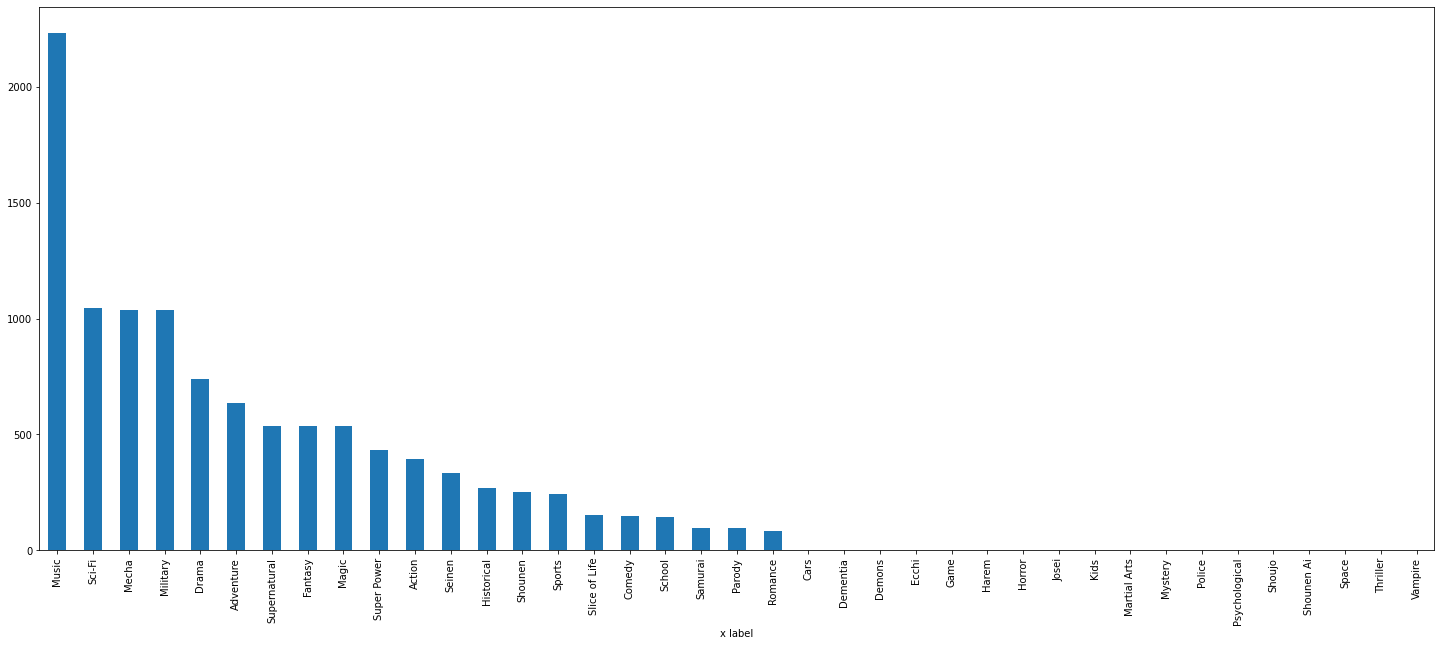

In [ ]:
df_reviews_genres_grouped['helpful1'].sort_values(ascending=False).plot.bar(figsize = (25, 10)).set_xlabel("x label")
get_polar_votes(df_reviews_genres_grouped['helpful1'].sort_values(ascending=False).index[:5])

**I graphed the number of helpful votes for each score by genre. Ie Out of all "music" anime in the top 450, the top 4 reviews with a "1" rating recieved a total of about 2500 helpful votes. Music, Sci-Fi, Mecha, Military, and Drama all get one polar vote.**

I then added one polar vote to the top 5 genres with the most "helpful" votes on reviews with a 1 rating, because a rating of 1 is the lowest and it is very contraversial to give any anime in the top 450 a rating of 1, but a number of people voted "helpful" on the review.

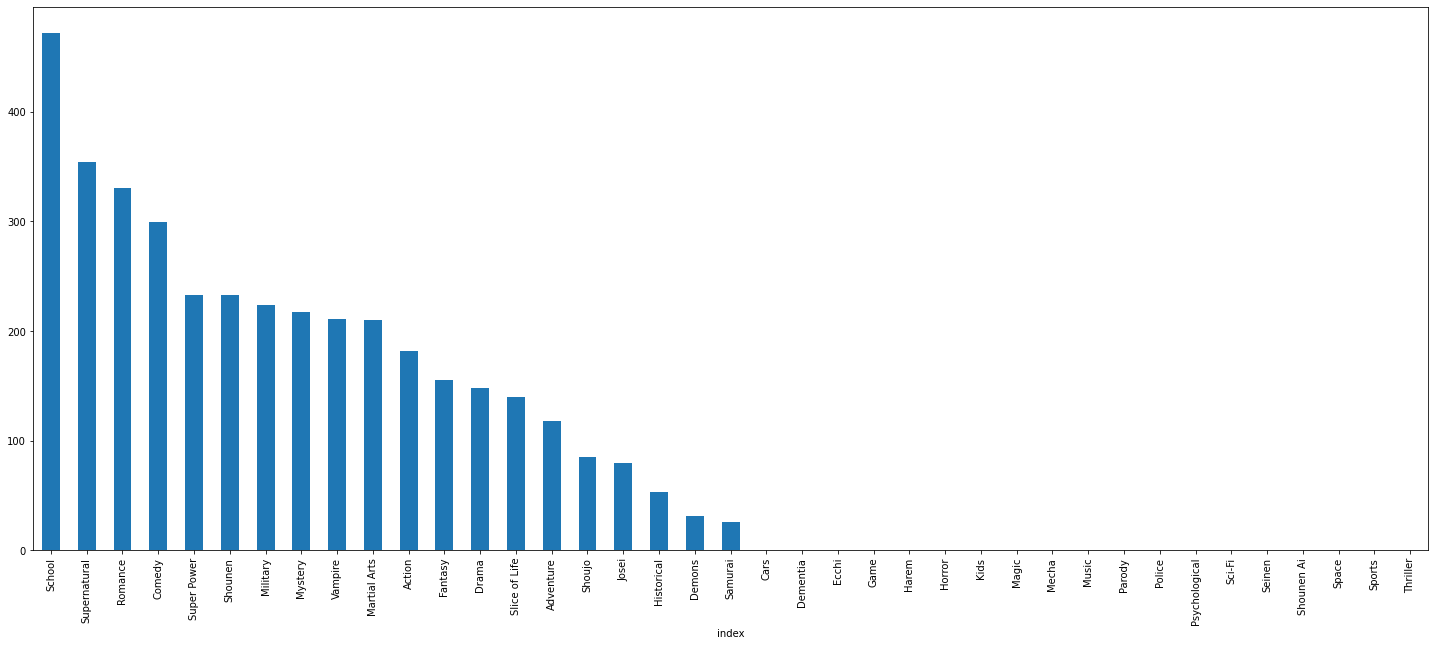

In [ ]:
df_reviews_genres_grouped['helpful2'].sort_values(ascending=False).plot.bar(figsize = (25, 10))
get_polar_votes(df_reviews_genres_grouped['helpful2'].sort_values(ascending=False).index[:5])

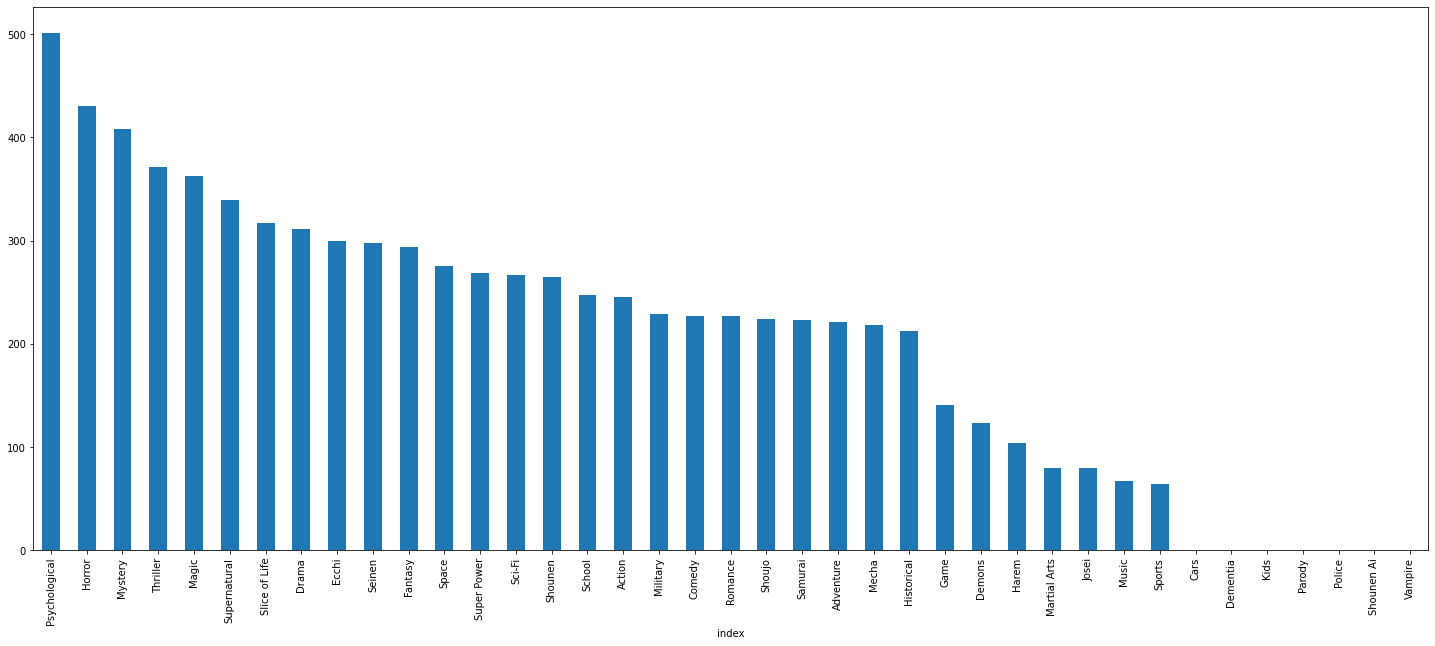

In [ ]:
df_reviews_genres_grouped['helpful3'].sort_values(ascending=False).plot.bar(figsize = (25, 10))
get_polar_votes(df_reviews_genres_grouped['helpful3'].sort_values(ascending=False).index[:5])

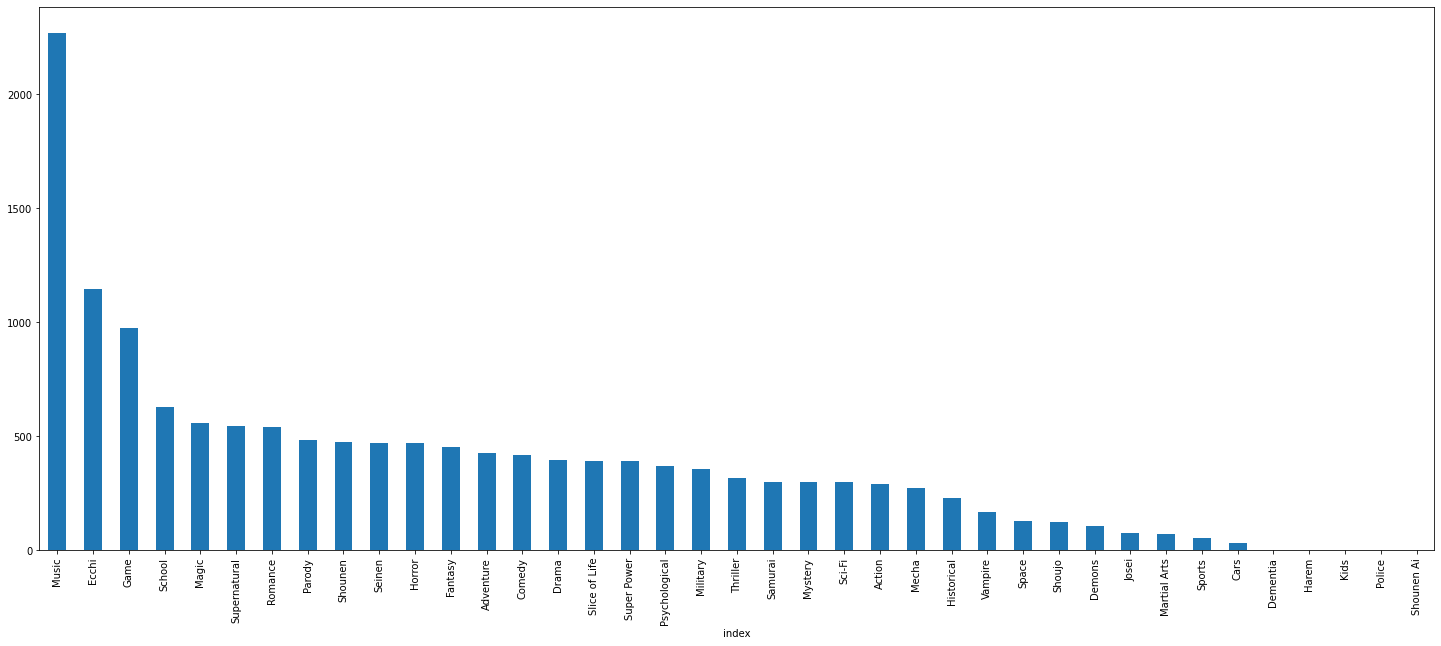

In [ ]:
df_reviews_genres_grouped['helpful4'].sort_values(ascending=False).plot.bar(figsize = (25, 10))
get_polar_votes(df_reviews_genres_grouped['helpful4'].sort_values(ascending=False).index[:5])

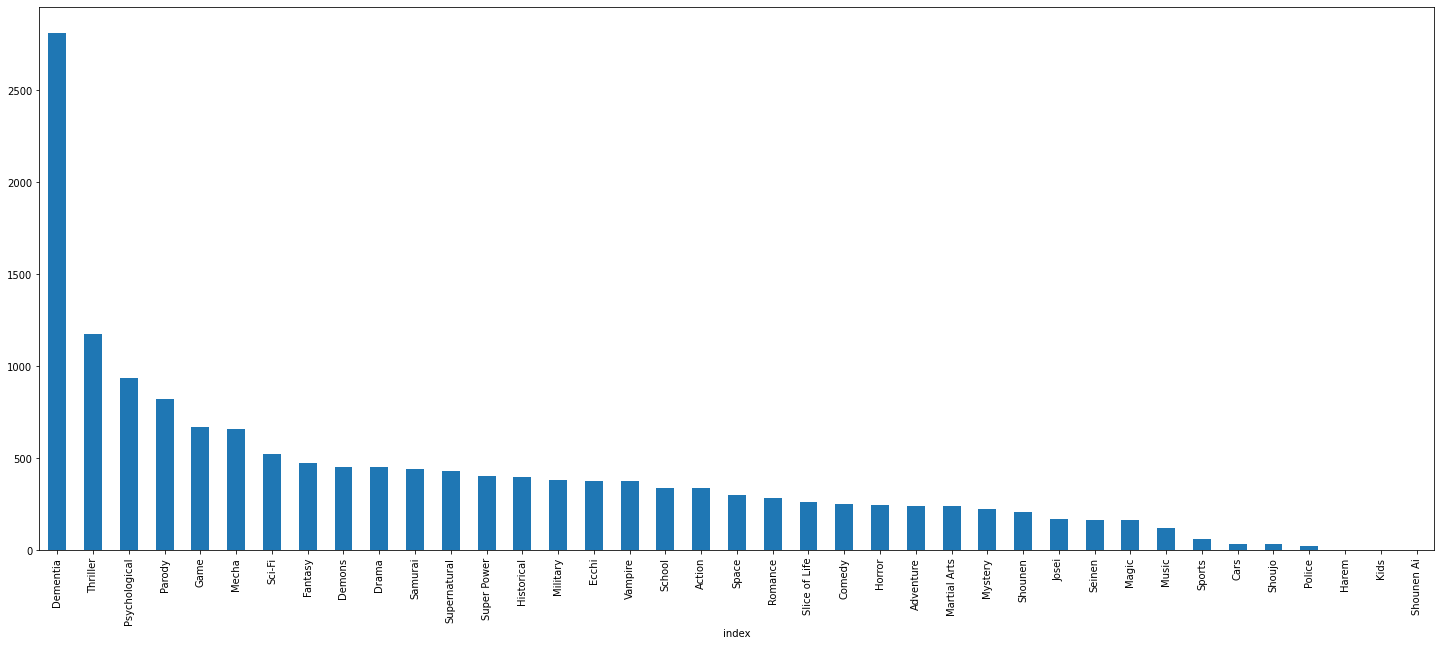

In [ ]:
df_reviews_genres_grouped['helpful5'].sort_values(ascending=False).plot.bar(figsize = (25, 10))
get_polar_votes(df_reviews_genres_grouped['helpful5'].sort_values(ascending=False).index[:5])

**For the genres with the top 5 most "helpful" votes on reviews with a 1-5 rating, they recieve 1 "polar vote." These Genre recieve a polar vote because a rating of 1-5 is contraversial to give any anime in the top 450, but a number of people voted "helpful" on the review, which indicates polarity.**

I repeated the process for every possible score (1-10). I gave polar points to every genre having the top 5 most helpful votes for reviews with score 1, 2, 3, 4, or 5. I did not give polar points to any genres with score 6, 7, 8, 9, 10, because these are not really contraversial scores. 

In [ ]:
polar_votes

{'Comedy': 1,
 'Dementia': 1,
 'Drama': 1,
 'Ecchi': 1,
 'Game': 2,
 'Horror': 1,
 'Magic': 2,
 'Mecha': 1,
 'Military': 1,
 'Music': 2,
 'Mystery': 1,
 'Parody': 1,
 'Psychological': 2,
 'Romance': 1,
 'School': 2,
 'Sci-Fi': 1,
 'Super Power': 1,
 'Supernatural': 1,
 'Thriller': 2}

**This is what the polar votes dictionary looks like now.**

**Part 2**

This is the breakdown of each genres polar votes. Some of the genres are not shown because they have polar scores of 0. It seems dementia, kids, mecha, music, parody, and space are the most polar genres. However, just using the frequency helpful votes appeared on low rating reviews is not the only factor that displays polarization.

Working with stats

In [ ]:
# get the stats for each of the top 500 anime
data_top500 = []

for x in range(len(top500)):
  response = requests.get("https://api.jikan.moe/v3/anime/" + str(top500[x]) + '/stats')
  data_top500.append(response.json()['scores'])

df_stats = json_normalize(data_top500)

Each row is an anime, each column is a feature of the anime.

I read in the number and percentage of each score (1-10) for every anime in the top 450. These scores represent all scores given to each anime, ie the first anime had 7124 users who gave the anime a 1, which makes up .7% of all scores given. The mean of all scores in a row is the overall score of the anime. 

In [ ]:
df_stats_genres = pd.DataFrame()

for x in range(0, len(df_data)):
  for y in range(0, len(df_data['genres'][x])):
    df_stats_genres.insert(x, str(df_data['genres'][x][y]['name']), df_stats.loc[x], allow_duplicates=True)

df_stats_genres = df_stats_genres.transpose()

Each row is a genre with a corresponding movie, columns are the same as above.

In [ ]:
df_stats_genres.reset_index(inplace=True)
df_stats_genres_grouped = df_stats_genres.groupby('index').mean()

In [ ]:
# make a dataframe vote percentage only
df_stats_genres_percent = df_stats_genres_grouped.drop(['1.votes', '2.votes', '3.votes', '4.votes', '5.votes',
                              '6.votes', '7.votes', '8.votes', '9.votes', '10.votes'], axis = 1)
df_stats_genres_percent

,1.percentage,2.percentage,3.percentage,4.percentage,5.percentage,6.percentage,7.percentage,8.percentage,9.percentage,10.percentage
index,,,,,,,,,,
Action,0.603468,0.195954,0.317341,0.706358,1.843931,4.673410,14.415029,27.971098,26.828324,22.436416
Adventure,0.428155,0.163107,0.281553,0.699029,1.944660,4.920388,14.930097,28.025243,26.487379,22.133010
Cars,0.283333,0.083333,0.166667,0.600000,1.850000,5.283333,17.466667,31.766667,24.416667,18.066667
Comedy,0.519903,0.184951,0.279126,0.677184,1.930583,4.883495,15.043689,28.480097,26.420874,21.588835
Dementia,0.500000,0.400000,0.500000,1.100000,2.033333,4.833333,12.666667,23.700000,26.433333,27.766667
Demons,0.432000,0.124000,0.208000,0.564000,1.668000,4.536000,14.480000,28.436000,27.008000,22.576000
Drama,0.580328,0.187432,0.303825,0.734426,1.904918,4.684699,13.934426,27.127869,27.238798,23.298361
Ecchi,0.255556,0.177778,0.333333,0.788889,1.833333,4.833333,15.722222,31.477778,27.333333,17.266667
Fantasy,0.442222,0.163333,0.284444,0.716667,1.867778,4.731111,14.312222,27.518889,27.033333,22.944444


Each row is a genre, each column is the percentage of users that gave the anime the corresponding score. Ie on average, 0.603468% of the top 450 anime recieved a user given score of 1. This dataframe is too complex to draw conclusions from, so I analyzed each genre by score. 

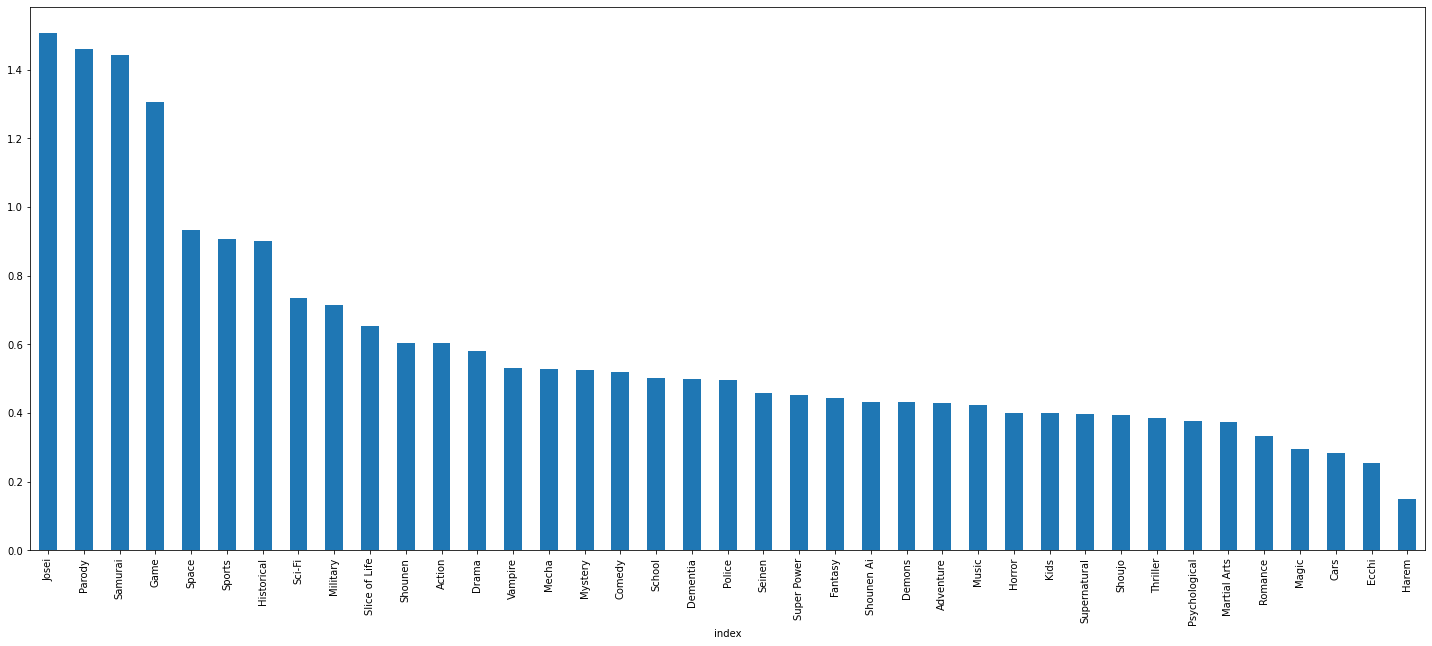

In [ ]:
df_stats_genres_percent['1.percentage'].sort_values(ascending=False).plot.bar(figsize = (25, 10))
get_polar_votes(df_stats_genres_percent['1.percentage'].sort_values(ascending=False).index[:5])

**I graphed the percentage of votes for each score by genre. Ie Out of all "josei" anime in the top 450, about 1.5% of users who rated the anime gave the anime a score of 1.**

**I used the same process as above but with different criteria. The top 5 genres with the highest percentage of users giving a score 1-5 were given a polar vote**

I used the same "polar_votes" dictionary that was keeping track of if a genre seems polar. For the genres with the top 5 highest percetnage of users giving a 1 rating, they recieve 1 "polar point." Genres with the top 5 highest percentage of users giving a 1 rating recieve a polar vote because a rating of 1 is the lowest and it is very contraversial to give any anime in the top 450 a rating of 1.

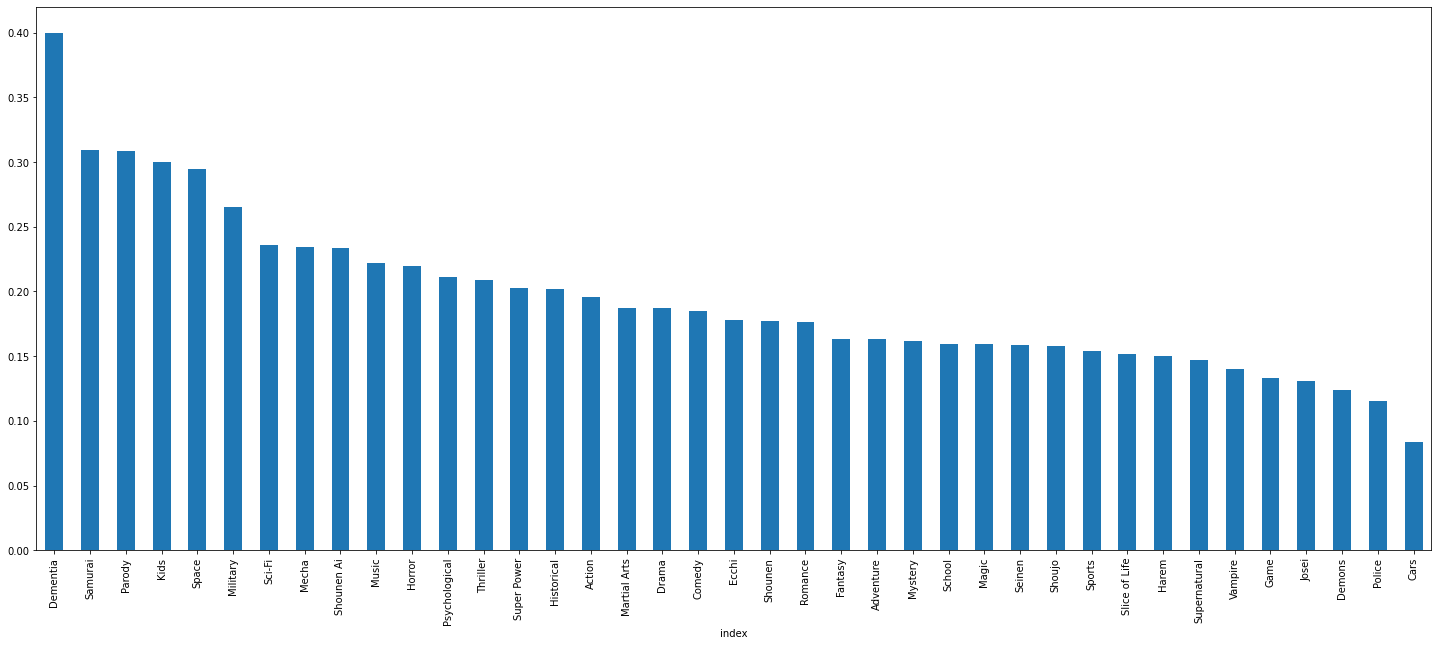

In [ ]:
df_stats_genres_percent['2.percentage'].sort_values(ascending=False).plot.bar(figsize = (25, 10))
get_polar_votes(df_stats_genres_percent['2.percentage'].sort_values(ascending=False).index[:5])

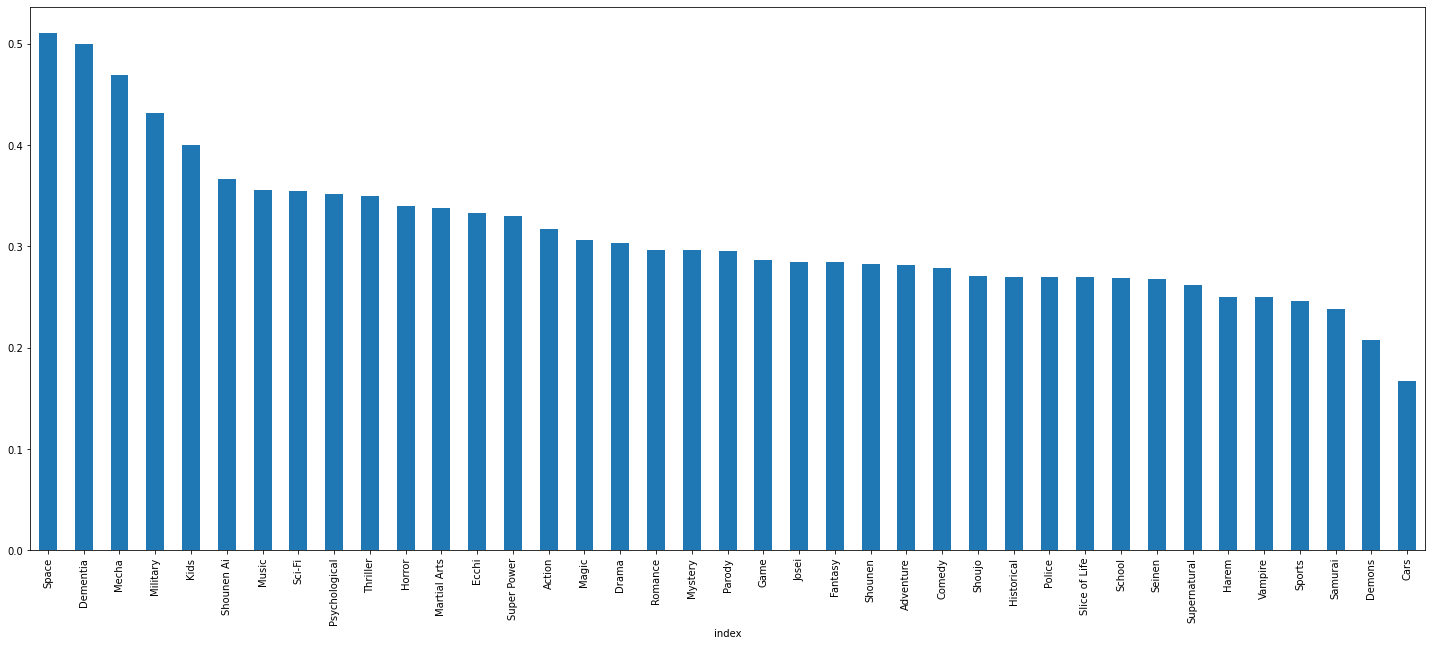

In [ ]:
df_stats_genres_percent['3.percentage'].sort_values(ascending=False).plot.bar(figsize = (25, 10))
get_polar_votes(df_stats_genres_percent['3.percentage'].sort_values(ascending=False).index[:5])

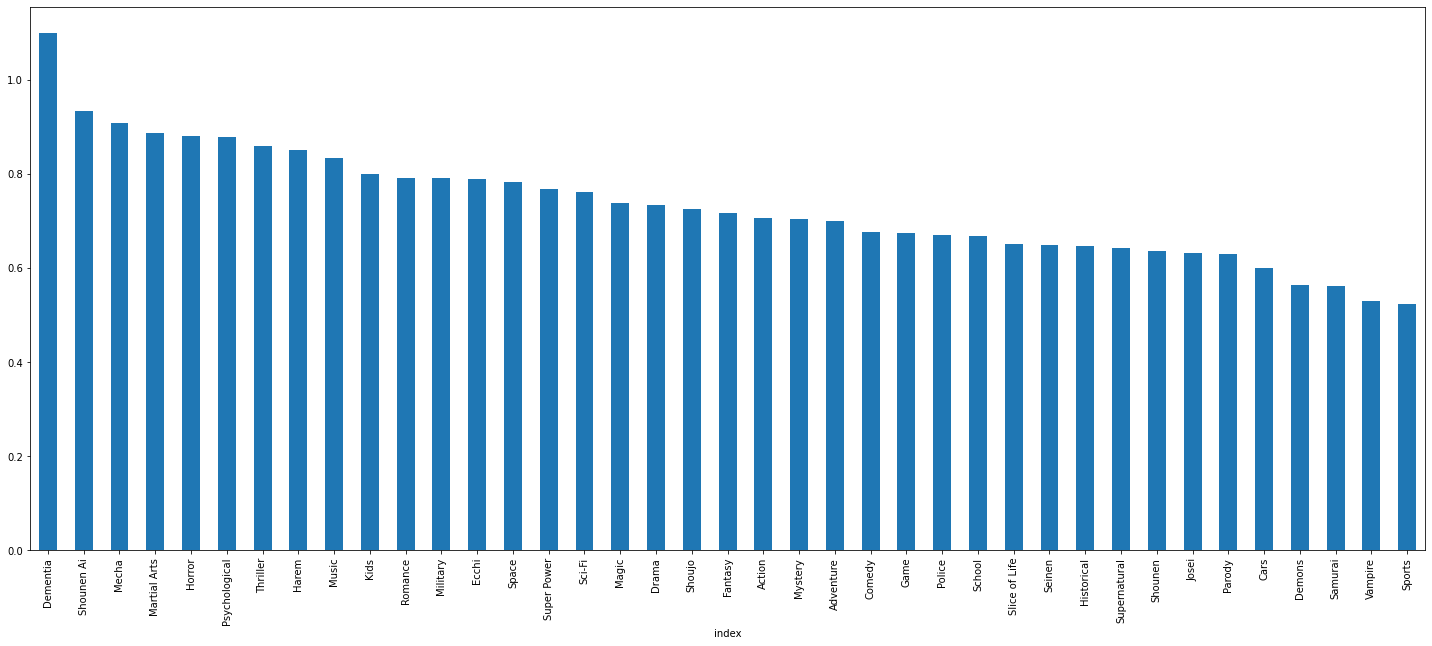

In [ ]:
df_stats_genres_percent['4.percentage'].sort_values(ascending=False).plot.bar(figsize = (25, 10))
get_polar_votes(df_stats_genres_percent['4.percentage'].sort_values(ascending=False).index[:5])

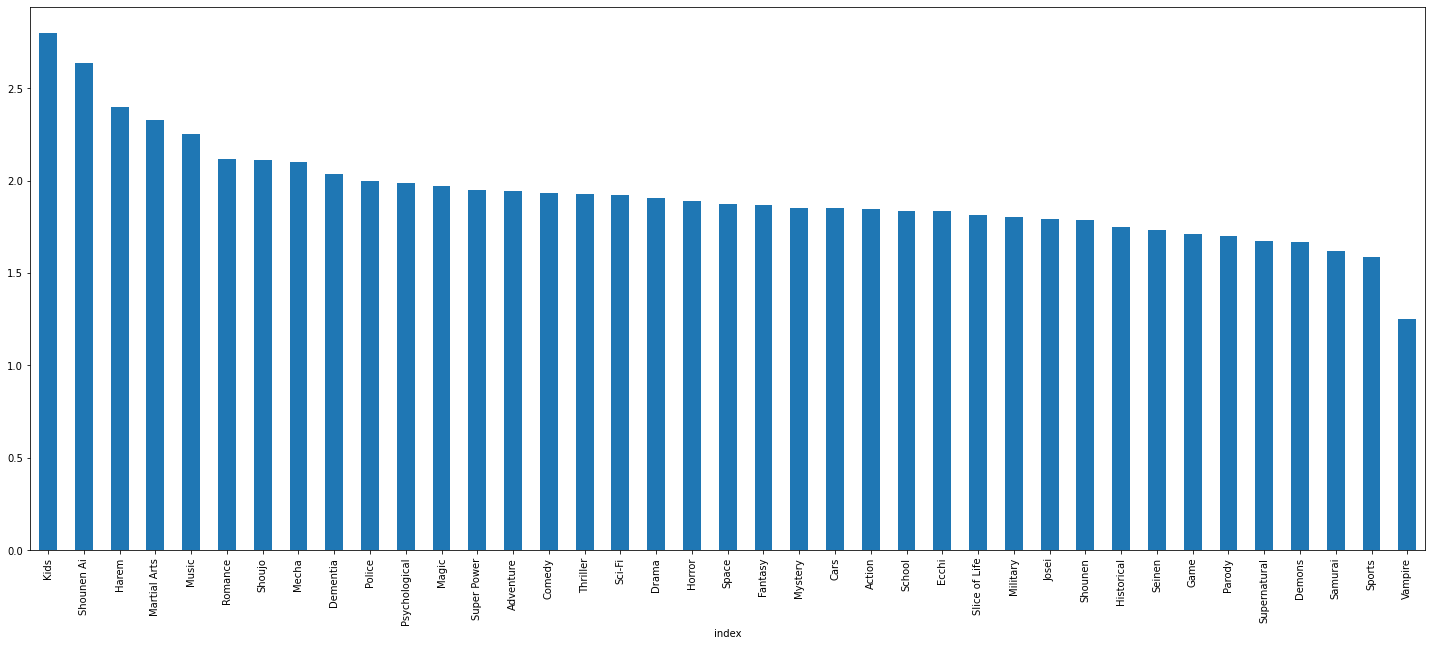

In [ ]:
df_stats_genres_percent['5.percentage'].sort_values(ascending=False).plot.bar(figsize = (25, 10))
get_polar_votes(df_stats_genres_percent['5.percentage'].sort_values(ascending=False).index[:5])

I repeated the process for every possible score (1-10). I gave polar points to every genre having the top 5 highest percentage of users giving scores of 1, 2, 3, 4, or 5. I did not give polar points to any genres with users giving scores of 6, 7, 8, 9, 10, because these are not really contraversial scores. 

In [ ]:
pd.Series(polar_votes).sort_values(ascending=False)

Dementia         4
Music            3
Parody           3
Mecha            3
Game             3
Space            3
Kids             3
Samurai          2
Shounen Ai       2
Magic            2
Thriller         2
Martial Arts     2
Horror           2
Psychological    2
Military         2
School           2
Sci-Fi           1
Supernatural     1
Drama            1
Harem            1
Romance          1
Comedy           1
Super Power      1
Ecchi            1
Josei            1
Mystery          1
dtype: int64

**The updated polar_votes dictionary. Genres with polar votes 2 or higher I deemed were suspicious of being polar. This was: 'Dementia', 'Game', 'Kids', 'Mecha',
          'Music', 'Parody', 'Space', 'Horror',
          'Magic', 'Martial Arts', 'Military',
          'Psychological', 'Samurai', 'School',
          'Shounen Ai', 'Thriller'.**

**Part 3**

In [ ]:
genres = ['Dementia', 'Game', 'Kids', 'Mecha',
          'Music', 'Parody', 'Space', 'Horror',
          'Magic', 'Martial Arts', 'Military',
          'Psychological', 'Samurai', 'School',
          'Shounen Ai', 'Thriller', 'Other']
values = [4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
df_polar = pd.DataFrame(values, index = genres, columns = ['count'])

for x in range(1, 11):
  df_polar[str(x)]  = np.nan

In [ ]:
for x in range(len(df_reviews_genres)):
  for y in range(min(4, len(df_reviews_genres['reviews'][x]))):
    mean = (df_reviews_genres['reviews'][x][y]['reviewer']['scores']['overall'])
    if df_reviews_genres['index'][x] == 'Dementia':
      if df_polar[str(round(mean))][0] > 0:
        df_polar[str(round(mean))][0] += 1
      else:
        df_polar[str(round(mean))][0] = 1
    elif df_reviews_genres['index'][x] == 'Game':
      if df_polar[str(round(mean))][1] > 0:
        df_polar[str(round(mean))][1] += 1
      else:
        df_polar[str(round(mean))][1] = 1    
    elif df_reviews_genres['index'][x] == 'Kids':
      if df_polar[str(round(mean))][2] > 0:
        df_polar[str(round(mean))][2] += 1
      else:
        df_polar[str(round(mean))][2] = 1
    elif df_reviews_genres['index'][x] == 'Mecha':
      if df_polar[str(round(mean))][3] > 0:
        df_polar[str(round(mean))][3] += 1
      else:
        df_polar[str(round(mean))][3] = 1
    elif df_reviews_genres['index'][x] == 'Music':
      if df_polar[str(round(mean))][4] > 0:
        df_polar[str(round(mean))][4] += 1
      else:
        df_polar[str(round(mean))][4] = 1
    elif df_reviews_genres['index'][x] == 'Parody':
      if df_polar[str(round(mean))][5] > 0:
        df_polar[str(round(mean))][5] += 1
      else:
        df_polar[str(round(mean))][5] = 1
    elif df_reviews_genres['index'][x] == 'Space':
      if df_polar[str(round(mean))][6] > 0:
        df_polar[str(round(mean))][6] += 1
      else:
        df_polar[str(round(mean))][6] = 1
    elif df_reviews_genres['index'][x] == 'Horror':
      if df_polar[str(round(mean))][7] > 0:
        df_polar[str(round(mean))][7] += 1
      else:
        df_polar[str(round(mean))][7] = 1
    elif df_reviews_genres['index'][x] == 'Magic':
      if df_polar[str(round(mean))][8] > 0:
        df_polar[str(round(mean))][8] += 1
      else:
        df_polar[str(round(mean))][8] = 1
    elif df_reviews_genres['index'][x] == 'Martial Arts':
      if df_polar[str(round(mean))][9] > 0:
        df_polar[str(round(mean))][9] += 1
      else:
        df_polar[str(round(mean))][9] = 1
    elif df_reviews_genres['index'][x] == 'Military':
      if df_polar[str(round(mean))][10] > 0:
        df_polar[str(round(mean))][10] += 1
      else:
        df_polar[str(round(mean))][10] = 1
    elif df_reviews_genres['index'][x] == 'Psychological':
      if df_polar[str(round(mean))][11] > 0:
        df_polar[str(round(mean))][11] += 1
      else:
        df_polar[str(round(mean))][11] = 1
    elif df_reviews_genres['index'][x] == 'Samurai':
      if df_polar[str(round(mean))][12] > 0:
        df_polar[str(round(mean))][12] += 1
      else:
        df_polar[str(round(mean))][12] = 1
    elif df_reviews_genres['index'][x] == 'School':
      if df_polar[str(round(mean))][13] > 0:
        df_polar[str(round(mean))][13] += 1
      else:
        df_polar[str(round(mean))][13] = 1
    elif df_reviews_genres['index'][x] == 'Shounen Ai':
      if df_polar[str(round(mean))][14] > 0:
        df_polar[str(round(mean))][14] += 1
      else:
        df_polar[str(round(mean))][14] = 1
    elif df_reviews_genres['index'][x] == 'Thriller':
      if df_polar[str(round(mean))][15] > 0:
        df_polar[str(round(mean))][15] += 1
      else:
        df_polar[str(round(mean))][15] = 1
    if df_polar[str(round(mean))][16] > 0:
      df_polar[str(round(mean))][16] += 1
    else:
      df_polar[str(round(mean))][16] = 1


Each row is a genre, each column is the number of top 4 reviews given by users with a corresponding score. Ie for dementia anime, there were 2 reviews with a score of "5", 1 review with a score of "8", 2 reviews with a score of "9", and 7 reviews with a score of "10" in the top 4 for all dementia anime in the top 450.

I created this dataframe to compare the number of scores of top 4 reviews for each genre that I marked as having a polar vote 2 or higher. The row "other" represents the total number of reviews with corresponding scores for genres not having a polar vote of 2 of higher.  

In [ ]:
df_polar['count'] = 0
df_polar = df_polar.div(df_polar.sum(axis=1), axis=0) * 100
df_polar.fillna(0, inplace= True)
df_polar

,count,1,2,3,4,5,6,7,8,9,10
Dementia,0.0,0.000000,0.000000,0.000000,0.000000,16.666667,0.000000,0.000000,8.333333,16.666667,58.333333
Game,0.0,0.000000,0.000000,5.172414,3.448276,3.448276,6.896552,1.724138,18.965517,27.586207,32.758621
Kids,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,25.000000,25.000000
Mecha,0.0,1.000000,0.000000,6.000000,2.000000,7.000000,8.000000,11.000000,9.000000,20.000000,36.000000
Music,0.0,1.388889,0.000000,4.166667,1.388889,5.555556,0.000000,2.777778,15.277778,33.333333,36.111111
Parody,0.0,1.428571,0.000000,0.000000,4.285714,2.857143,10.000000,11.428571,17.142857,17.142857,35.714286
Space,0.0,0.000000,0.000000,4.411765,1.470588,7.352941,2.941176,8.823529,16.176471,25.000000,33.823529
Horror,0.0,0.000000,0.000000,2.500000,2.500000,5.000000,5.000000,5.000000,12.500000,27.500000,40.000000
Magic,0.0,0.781250,0.000000,2.343750,3.125000,3.125000,6.250000,9.375000,14.843750,31.250000,28.906250
Martial Arts,0.0,0.000000,3.125000,3.125000,3.125000,3.125000,3.125000,6.250000,12.500000,25.000000,40.625000


**Each row is a genre, each column is the percentage of reviews with corresponding scores for all top 4 reviews of that genre. Ie for dementia 16.6% of top 4 reviews were given a score of 5, 8.3% of top 4 reviews were given a score of 8, 16.6% of top 4 reviews were given a score of 9, and 58.3% of scores were given a score of 10. The "other" row is the mean of all genres not listed explicitly.**

The DatFrame above is the same as the DataFrame before it but in percentage view. From comparing each row with the other row, the genres with high polarization seem to be dementia, game, music, parody, samurai, school. 

In [ ]:
dict_polar = {}

for x in range(len(df_polar)):
  bottom = 0
  for y in range(1, 6):
    bottom += df_polar[str(y)][x]
  dict_polar[df_polar.index[x]] = (round(bottom, 1))

In [ ]:
dict_polar

{'Dementia': 16.7,
 'Game': 12.1,
 'Horror': 10.0,
 'Kids': 0.0,
 'Magic': 9.4,
 'Martial Arts': 12.5,
 'Mecha': 16.0,
 'Military': 11.3,
 'Music': 12.5,
 'Other': 11.7,
 'Parody': 8.6,
 'Psychological': 14.0,
 'Samurai': 9.2,
 'School': 16.0,
 'Shounen Ai': 0.0,
 'Space': 13.2,
 'Thriller': 9.1}

**I added the percentage of the top 4 reviews that were 5 and below, so that it was easier to compare to the "other" percentage of values 5 and below. This makes sense, because if I was comparing every score (1-10) for each genre, I would be comparing "0" to the percentage of "other" alot.**

In [ ]:
for x in dict_polar:
  dict_polar[x] = round(dict_polar[x] - 11.7, 1)

pd.Series(dict_polar).sort_values(ascending=False)

Dementia          5.0
School            4.3
Mecha             4.3
Psychological     2.3
Space             1.5
Music             0.8
Martial Arts      0.8
Game              0.4
Other             0.0
Military         -0.4
Horror           -1.7
Magic            -2.3
Samurai          -2.5
Thriller         -2.6
Parody           -3.1
Kids            -11.7
Shounen Ai      -11.7
dtype: float64

**I subtracted "other" from every value in the dictionary to determine the values that had the greatest deviation of percentage of values 5 and below from other. It seems dementia, mecha, parody, school, and thriller deviate the most.**

In [ ]:
polar_votes['Dementia'] += 1
polar_votes['Mecha'] += 1
polar_votes['School'] += 1
polar_votes['Psychological'] += 1
polar_votes['Space'] += 1

**I gave the five listed genres above 1 more polar vote, because a high percentage of the top 4 scores being 5 or below is contraversial.**

**Part 4**

In [ ]:
df_stats_genres_percent

,1.percentage,2.percentage,3.percentage,4.percentage,5.percentage,6.percentage,7.percentage,8.percentage,9.percentage,10.percentage
index,,,,,,,,,,
Action,0.603468,0.195954,0.317341,0.706358,1.843931,4.673410,14.415029,27.971098,26.828324,22.436416
Adventure,0.428155,0.163107,0.281553,0.699029,1.944660,4.920388,14.930097,28.025243,26.487379,22.133010
Cars,0.283333,0.083333,0.166667,0.600000,1.850000,5.283333,17.466667,31.766667,24.416667,18.066667
Comedy,0.519903,0.184951,0.279126,0.677184,1.930583,4.883495,15.043689,28.480097,26.420874,21.588835
Dementia,0.500000,0.400000,0.500000,1.100000,2.033333,4.833333,12.666667,23.700000,26.433333,27.766667
Demons,0.432000,0.124000,0.208000,0.564000,1.668000,4.536000,14.480000,28.436000,27.008000,22.576000
Drama,0.580328,0.187432,0.303825,0.734426,1.904918,4.684699,13.934426,27.127869,27.238798,23.298361
Ecchi,0.255556,0.177778,0.333333,0.788889,1.833333,4.833333,15.722222,31.477778,27.333333,17.266667
Fantasy,0.442222,0.163333,0.284444,0.716667,1.867778,4.731111,14.312222,27.518889,27.033333,22.944444


I made this dataframe earlier, I need to use it again.

In [ ]:
other = pd.Series()

for x in df_stats_genres_percent.columns:
  other[x] = df_stats_genres_percent[x].mean()

other

1.percentage      0.591345
2.percentage      0.194589
3.percentage      0.312425
4.percentage      0.733002
5.percentage      1.923701
6.percentage      4.790679
7.percentage     14.450891
8.percentage     27.798770
9.percentage     26.767058
10.percentage    22.433670
dtype: float64

I added a row "other" representing all the genres, thus the column values are the mean of all the other column values.

In [ ]:
pd.Series(polar_votes).sort_values(ascending=False)

Dementia         5
Mecha            4
Space            4
Music            3
Parody           3
Psychological    3
Game             3
Kids             3
School           3
Samurai          2
Magic            2
Thriller         2
Martial Arts     2
Horror           2
Shounen Ai       2
Military         2
Sci-Fi           1
Supernatural     1
Drama            1
Harem            1
Romance          1
Comedy           1
Super Power      1
Ecchi            1
Josei            1
Mystery          1
dtype: int64

In [ ]:
dif = pd.DataFrame()

for x in ['Dementia', 'Game', 'Music', 'Kids', 'Parody', 'Space', 'School', 'Mecha', 'Thriller']:
  dif[x] = abs(df_stats_genres_percent.loc[x] - other)

dif.transpose()

,1.percentage,2.percentage,3.percentage,4.percentage,5.percentage,6.percentage,7.percentage,8.percentage,9.percentage,10.percentage
Dementia,0.091345,0.205411,0.187575,0.366998,0.109632,0.042655,1.784225,4.098770,0.333724,5.332996
Game,0.715322,0.061256,0.025758,0.059669,0.210368,0.297345,0.604225,1.107897,1.286276,1.853670
Music,0.169123,0.027633,0.043131,0.100331,0.326299,0.437099,0.226886,0.526548,0.533724,0.082996
Kids,0.191345,0.105411,0.087575,0.066998,0.876299,1.509321,3.149109,2.901230,4.367058,4.133670
Parody,0.869525,0.114107,0.016773,0.102567,0.223701,0.677635,2.163935,4.150944,2.210536,8.579373
Space,0.341988,0.099855,0.198686,0.050331,0.051479,0.318457,0.434225,1.012341,0.699609,1.605893
School,0.090154,0.035065,0.043377,0.065145,0.090368,0.151393,0.237204,1.340516,0.810323,1.907480
Mecha,0.064422,0.040026,0.156806,0.174690,0.176299,0.255475,0.129878,0.156462,0.428596,0.299055
Thriller,0.204981,0.014502,0.037575,0.126089,0.003571,0.227042,1.387255,1.344224,1.478397,1.507239


**Each row is a genre, each column is the difference of the percentage of users who gave the corresponding score for each genre and the average of the percentage of users who gave the corresponding score. Ie for dementia .09% of users give more or less 1s than the average genre.**

In [ ]:
pd.Series(dif.sum()).sort_values(ascending=False)

Parody      19.109095
Kids        17.388016
Dementia    12.553331
Thriller     6.330876
Game         6.221785
Space        4.812865
School       4.771026
Music        2.473770
Mecha        1.881709
dtype: float64

In [ ]:
polar_votes['Dementia'] += 1
polar_votes['Kids'] += 1
polar_votes['Parody'] += 1
polar_votes['Game'] += 1
polar_votes['Thriller'] += 1

**I gave each of these genres polar votes, because it is contraversial to have a high percentage of users giving scores different from the mean.**

In [ ]:
pd.Series(polar_votes).sort_values(ascending=False)

Dementia         6
Game             4
Kids             4
Space            4
Mecha            4
Parody           4
Psychological    3
Thriller         3
Music            3
School           3
Magic            2
Samurai          2
Martial Arts     2
Horror           2
Shounen Ai       2
Military         2
Supernatural     1
Sci-Fi           1
Drama            1
Harem            1
Romance          1
Comedy           1
Super Power      1
Ecchi            1
Josei            1
Mystery          1
dtype: int64

**Using my polar_votes dictionary, some genres do seem to cause or at least correlate with polarity. The fact that some genres consistently had patterns in voting and scores by users implies some sort of causation between genre and polarization. I would make the assumption given my observations that anime of the dementia genre cause the most polarity. It is important to understand that my "polar votes" is a measurement that I made up. The reality is that some features may have more indication of polarity than others, but there is no numeric or objective measure of polarity.**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

linear_model = pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

knn_model = pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=3)
)

from sklearn.ensemble import StackingRegressor

X_train = df_data[["popularity", "score", "favorites", "scored_by"]]

stacking_model = StackingRegressor([
    ("linear", linear_model), 
    ("knn", knn_model)],
    final_estimator=LinearRegression()
)
-cross_val_score(stacking_model, X=X_train, y=df_data['members'], cv=10,
                 scoring="neg_root_mean_squared_error").mean()


34996.14076100834

**Small portion of ML part.**

To recap, the measures of polarity I used are:


*   Top five genres with the most helpful votes on top 4 ratings with a score of 1
*   Top five genres with the most helpful votes on top 4 ratings with a score of 2
*   Top five genres with the most helpful votes on top 4 ratings with a score of 3
*   Top five genres with the most helpful votes on top 4 ratings with a score of 4
*   Top five genres with the most helpful votes on top 4 ratings with a score of 5

*   Top five genres with the highest percentage of users giving a score of 1
*   Top five genres with the highest percentage of users giving a score of 2
*   Top five genres with the highest percentage of users giving a score of 3
*   Top five genres with the highest percentage of users giving a score of 4
*   Top five genres with the highest percentage of users giving a score of 5

*   Top five genres with the highest percentage of top 4 reviews giving scores 1-5 
*   Top five genres with the highest percentage of users giving scores that deviate from the mean scores



